<a href="https://colab.research.google.com/github/kachmaryk/computer_vision/blob/main/lab_3/lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import time
import os
import copy
import cv2
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

path_to_models = '/content/gdrive/MyDrive/Colab Notebooks/Image_Processing_2022/lab_3_saved_models/'

Mounted at /content/gdrive


# DenseNet

In [5]:
def train_model(model, criterion, optimizer, data_loaders,
                batch_size, num_epochs=30):
  start_time = time.time()

  train_acc_history = []
  val_acc_history = []

  best_model_over_epochs = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    # Train and validate over each epoch
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      batch_loss = 0.0
      batch_correct_preds = 0

      # Iterate over data
      for inputs, labels in tqdm(data_loaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          # Get model outputs and calculate loss
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)
          
          # Backward + Optimize only in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        batch_loss += loss.item() * inputs.size(0)
        batch_correct_preds += torch.sum(preds == labels.data)
      
      epoch_loss = batch_loss / len(data_loaders[phase].dataset)
      epoch_acc = batch_correct_preds.double() / len(data_loaders[phase].dataset)

      print('-' * 50)
      print('{} Loss: {:.4f}  Acc: {:.4f}\n\n'.format(phase,
                                                      epoch_loss,
                                                      epoch_acc))

      # Deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_over_epochs = copy.deepcopy(model.state_dict())
      
      if phase == 'val':
        val_acc_history.append(epoch_acc)
      else:
        train_acc_history.append(epoch_acc)

  time_elapsed = time.time() - start_time
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                      time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # Load best model weights
  model.load_state_dict(best_model_over_epochs)
  
  # Save best model weights
  torch.save(model.state_dict(), path_to_models + f'model_weights_epoch-{num_epochs}_batch_size-{batch_size}_transform.pth')

  return model, train_acc_history, val_acc_history

In [6]:
def visualize_acc_hist(train_acc_history, val_acc_history):
  train_hist = [h.cpu().numpy() for h in train_acc_history]
  val_hist = [h.cpu().numpy() for h in val_acc_history]

  print('Training accuracy', np.around(np.array(train_hist), 3).reshape(len(train_hist),))
  print('Validation accuracy', np.around(np.array(val_hist), 3).reshape(len(val_hist),))

  plt.figure(figsize=(15, 9))
  plt.title("Accuracy over Number of Training Epochs", fontsize=15)
  plt.xlabel("Training Epochs", fontsize=14)
  plt.ylabel("Accuracy", fontsize=14)

  plt.plot(range(1, num_epochs+1), train_hist, label="Training", marker = 'o')
  # for a, b in zip(range(1, num_epochs+1), train_hist): 
  #     plt.text(a, b, str(np.around(b, 2)))
  plt.plot(range(1, num_epochs+1), val_hist, label="Validation", marker = 'o')
  # for a, b in zip(range(1, num_epochs+1), val_hist): 
  #     plt.text(a, b, str(np.around(b, 2)))
  plt.ylim((0,1.))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend(loc='lower left', fontsize=13)
  plt.show()

In [36]:
def show_statistics(y_test, y_pred, classNames):
  print("\n**** Classification Report ****")
  print(classification_report(y_test, y_pred, target_names=classNames))
  

def plot_confusion_matrix(y_test, y_pred, classNames):
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_pred)

    con = np.zeros((classes, classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] / np.sum(cm[x,:])

    plt.figure(figsize=(15,15))
    sns.set(font_scale=1.0)
    sns.heatmap(con, annot=True, fmt='.2', cmap='Blues',
                xticklabels=classNames, yticklabels=classNames)
    plt.show()

In [8]:
batch_size = 32
input_size = 224

data_transforms = {
    'train': transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(input_size),
                                 transforms.ToTensor(),
                                 transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])
                                ]),
    'val': transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(input_size),
                               transforms.ToTensor(),
                               transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                               ])
}

train_set = torchvision.datasets.FashionMNIST("./data",
                                              download=True,
                                              transform=data_transforms['train'])

val_set = torchvision.datasets.FashionMNIST("./data",
                                            download=True,
                                            train=False,
                                            transform=data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4)

val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4)

data_loaders = {'train': train_loader,
                'val': val_loader}

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



***Hyperparameters***

In [9]:
num_epochs = 30
num_classes = len(train_set.classes)
feature_extract = True

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

# Set all model parameters to not update
if feature_extract:
  for param in model.parameters():
    param.requires_grad = False

# Reinitialize layer’s parameters
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)

model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [11]:
# Send the model to GPU
model = model.to(device)

In [12]:
'''
Gather the parameters to be optimized/updated in this run. If we are
finetuning we will be updating all parameters. However, if we are
doing feature extract method, we will only update the parameters
that we will initialize, i.e. the parameters with requires_grad
is True
'''

params_to_update = model.parameters()
print("Params to learn:")

if feature_extract:
  params_to_update = []
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      print("\t",name)
else:
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.weight
	 classifier.bias


In [13]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model, train_history, val_history = train_model(model, criterion, optimizer,
                                                data_loaders, batch_size,
                                                num_epochs)

Epoch 0/29


100%|██████████| 1875/1875 [02:00<00:00, 15.61it/s]


--------------------------------------------------
train Loss: 0.6903  Acc: 0.7795




100%|██████████| 313/313 [00:18<00:00, 16.49it/s]


--------------------------------------------------
val Loss: 0.5186  Acc: 0.8205


Epoch 1/29


100%|██████████| 1875/1875 [01:59<00:00, 15.63it/s]


--------------------------------------------------
train Loss: 0.5000  Acc: 0.8274




100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


--------------------------------------------------
val Loss: 0.4681  Acc: 0.8351


Epoch 2/29


100%|██████████| 1875/1875 [01:59<00:00, 15.63it/s]


--------------------------------------------------
train Loss: 0.4675  Acc: 0.8360




100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


--------------------------------------------------
val Loss: 0.4483  Acc: 0.8383


Epoch 3/29


100%|██████████| 1875/1875 [02:00<00:00, 15.60it/s]


--------------------------------------------------
train Loss: 0.4478  Acc: 0.8443




100%|██████████| 313/313 [00:19<00:00, 16.37it/s]


--------------------------------------------------
val Loss: 0.4321  Acc: 0.8436


Epoch 4/29


100%|██████████| 1875/1875 [02:00<00:00, 15.59it/s]


--------------------------------------------------
train Loss: 0.4410  Acc: 0.8432




100%|██████████| 313/313 [00:18<00:00, 16.55it/s]


--------------------------------------------------
val Loss: 0.4277  Acc: 0.8451


Epoch 5/29


100%|██████████| 1875/1875 [01:59<00:00, 15.64it/s]


--------------------------------------------------
train Loss: 0.4328  Acc: 0.8461




100%|██████████| 313/313 [00:18<00:00, 16.47it/s]


--------------------------------------------------
val Loss: 0.4255  Acc: 0.8493


Epoch 6/29


100%|██████████| 1875/1875 [01:59<00:00, 15.64it/s]


--------------------------------------------------
train Loss: 0.4254  Acc: 0.8482




100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


--------------------------------------------------
val Loss: 0.4319  Acc: 0.8480


Epoch 7/29


100%|██████████| 1875/1875 [01:59<00:00, 15.63it/s]


--------------------------------------------------
train Loss: 0.4195  Acc: 0.8510




100%|██████████| 313/313 [00:18<00:00, 16.49it/s]


--------------------------------------------------
val Loss: 0.4241  Acc: 0.8484


Epoch 8/29


100%|██████████| 1875/1875 [02:00<00:00, 15.62it/s]


--------------------------------------------------
train Loss: 0.4165  Acc: 0.8515




100%|██████████| 313/313 [00:18<00:00, 16.52it/s]


--------------------------------------------------
val Loss: 0.4179  Acc: 0.8476


Epoch 9/29


100%|██████████| 1875/1875 [01:59<00:00, 15.64it/s]


--------------------------------------------------
train Loss: 0.4123  Acc: 0.8534




100%|██████████| 313/313 [00:18<00:00, 16.48it/s]


--------------------------------------------------
val Loss: 0.4109  Acc: 0.8537


Epoch 10/29


100%|██████████| 1875/1875 [01:59<00:00, 15.63it/s]


--------------------------------------------------
train Loss: 0.4102  Acc: 0.8539




100%|██████████| 313/313 [00:18<00:00, 16.50it/s]


--------------------------------------------------
val Loss: 0.4071  Acc: 0.8548


Epoch 11/29


100%|██████████| 1875/1875 [01:59<00:00, 15.63it/s]


--------------------------------------------------
train Loss: 0.4072  Acc: 0.8562




100%|██████████| 313/313 [00:18<00:00, 16.51it/s]


--------------------------------------------------
val Loss: 0.4069  Acc: 0.8569


Epoch 12/29


100%|██████████| 1875/1875 [01:59<00:00, 15.64it/s]


--------------------------------------------------
train Loss: 0.4084  Acc: 0.8545




100%|██████████| 313/313 [00:18<00:00, 16.47it/s]


--------------------------------------------------
val Loss: 0.4047  Acc: 0.8555


Epoch 13/29


100%|██████████| 1875/1875 [01:59<00:00, 15.63it/s]


--------------------------------------------------
train Loss: 0.4026  Acc: 0.8565




100%|██████████| 313/313 [00:19<00:00, 16.40it/s]


--------------------------------------------------
val Loss: 0.4095  Acc: 0.8535


Epoch 14/29


100%|██████████| 1875/1875 [01:59<00:00, 15.63it/s]


--------------------------------------------------
train Loss: 0.4033  Acc: 0.8575




100%|██████████| 313/313 [00:18<00:00, 16.48it/s]


--------------------------------------------------
val Loss: 0.4169  Acc: 0.8487


Epoch 15/29


100%|██████████| 1875/1875 [02:00<00:00, 15.62it/s]


--------------------------------------------------
train Loss: 0.4003  Acc: 0.8573




100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


--------------------------------------------------
val Loss: 0.4011  Acc: 0.8564


Epoch 16/29


100%|██████████| 1875/1875 [01:59<00:00, 15.63it/s]


--------------------------------------------------
train Loss: 0.3998  Acc: 0.8572




100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


--------------------------------------------------
val Loss: 0.4038  Acc: 0.8561


Epoch 17/29


100%|██████████| 1875/1875 [02:00<00:00, 15.60it/s]


--------------------------------------------------
train Loss: 0.3988  Acc: 0.8583




100%|██████████| 313/313 [00:18<00:00, 16.48it/s]


--------------------------------------------------
val Loss: 0.4054  Acc: 0.8565


Epoch 18/29


100%|██████████| 1875/1875 [02:00<00:00, 15.62it/s]


--------------------------------------------------
train Loss: 0.3945  Acc: 0.8596




100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


--------------------------------------------------
val Loss: 0.4006  Acc: 0.8585


Epoch 19/29


100%|██████████| 1875/1875 [02:00<00:00, 15.62it/s]


--------------------------------------------------
train Loss: 0.3967  Acc: 0.8578




100%|██████████| 313/313 [00:18<00:00, 16.52it/s]


--------------------------------------------------
val Loss: 0.4165  Acc: 0.8482


Epoch 20/29


100%|██████████| 1875/1875 [02:00<00:00, 15.61it/s]


--------------------------------------------------
train Loss: 0.3941  Acc: 0.8589




100%|██████████| 313/313 [00:18<00:00, 16.49it/s]


--------------------------------------------------
val Loss: 0.4007  Acc: 0.8572


Epoch 21/29


100%|██████████| 1875/1875 [02:00<00:00, 15.62it/s]


--------------------------------------------------
train Loss: 0.3932  Acc: 0.8586




100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


--------------------------------------------------
val Loss: 0.3972  Acc: 0.8591


Epoch 22/29


100%|██████████| 1875/1875 [02:00<00:00, 15.61it/s]


--------------------------------------------------
train Loss: 0.3906  Acc: 0.8590




100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


--------------------------------------------------
val Loss: 0.4000  Acc: 0.8581


Epoch 23/29


100%|██████████| 1875/1875 [02:00<00:00, 15.61it/s]


--------------------------------------------------
train Loss: 0.3924  Acc: 0.8594




100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


--------------------------------------------------
val Loss: 0.4016  Acc: 0.8549


Epoch 24/29


100%|██████████| 1875/1875 [02:00<00:00, 15.61it/s]


--------------------------------------------------
train Loss: 0.3911  Acc: 0.8612




100%|██████████| 313/313 [00:18<00:00, 16.48it/s]


--------------------------------------------------
val Loss: 0.3998  Acc: 0.8552


Epoch 25/29


100%|██████████| 1875/1875 [02:00<00:00, 15.62it/s]


--------------------------------------------------
train Loss: 0.3906  Acc: 0.8601




100%|██████████| 313/313 [00:19<00:00, 16.42it/s]


--------------------------------------------------
val Loss: 0.3999  Acc: 0.8605


Epoch 26/29


100%|██████████| 1875/1875 [02:00<00:00, 15.61it/s]


--------------------------------------------------
train Loss: 0.3916  Acc: 0.8617




100%|██████████| 313/313 [00:18<00:00, 16.49it/s]


--------------------------------------------------
val Loss: 0.4209  Acc: 0.8527


Epoch 27/29


100%|██████████| 1875/1875 [02:00<00:00, 15.60it/s]


--------------------------------------------------
train Loss: 0.3902  Acc: 0.8608




100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


--------------------------------------------------
val Loss: 0.4061  Acc: 0.8555


Epoch 28/29


100%|██████████| 1875/1875 [02:00<00:00, 15.61it/s]


--------------------------------------------------
train Loss: 0.3872  Acc: 0.8595




100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


--------------------------------------------------
val Loss: 0.4018  Acc: 0.8579


Epoch 29/29


100%|██████████| 1875/1875 [02:00<00:00, 15.61it/s]


--------------------------------------------------
train Loss: 0.3881  Acc: 0.8609




100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


--------------------------------------------------
val Loss: 0.3967  Acc: 0.8600


Training complete in 69m 32s
Best val Acc: 0.860500


Training accuracy [0.78  0.827 0.836 0.844 0.843 0.846 0.848 0.851 0.852 0.853 0.854 0.856
 0.855 0.857 0.857 0.857 0.857 0.858 0.86  0.858 0.859 0.859 0.859 0.859
 0.861 0.86  0.862 0.861 0.86  0.861]
Validation accuracy [0.82  0.835 0.838 0.844 0.845 0.849 0.848 0.848 0.848 0.854 0.855 0.857
 0.856 0.854 0.849 0.856 0.856 0.856 0.858 0.848 0.857 0.859 0.858 0.855
 0.855 0.86  0.853 0.856 0.858 0.86 ]


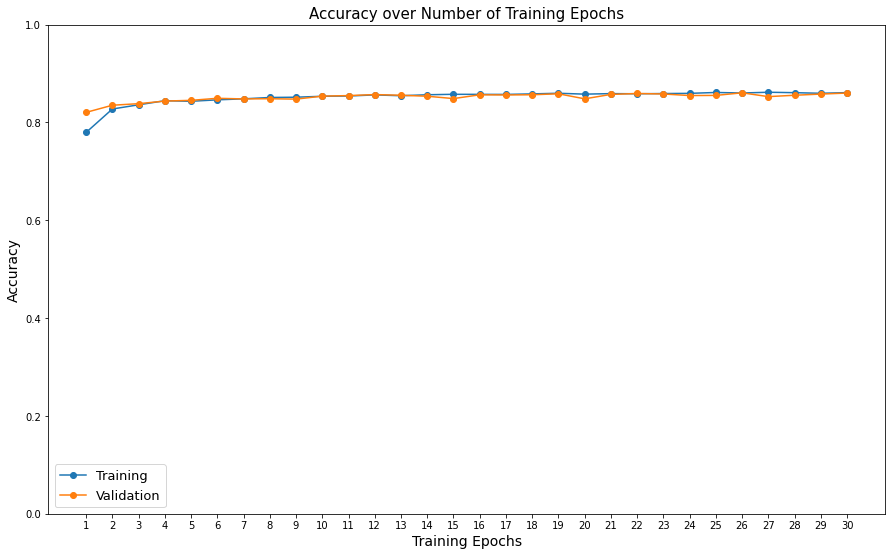

In [14]:
visualize_acc_hist(train_history, val_history)

In [15]:
test_labels = []
predict_labels = []

for inputs, labels in tqdm(data_loaders['val']):
  test_labels.extend(list(labels.detach().cpu().numpy()))

  inputs = inputs.to(device)
  labels = labels.to(device)

  predicted = model(inputs)
  _, preds = torch.max(predicted, 1)
  predict_labels.extend(list(preds.detach().cpu().numpy()))

print(test_labels)
print(predict_labels)

100%|██████████| 313/313 [00:18<00:00, 16.57it/s]

[9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9, 1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1, 2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 3, 9, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8, 0, 1, 4, 2, 3, 6, 7, 2, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8, 0, 0, 9, 9, 3, 0, 8, 4, 1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0, 1, 6, 1, 6, 2, 2, 4, 4, 1, 4, 5, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 7, 4, 2, 0, 5, 2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 6, 7, 9, 9, 4, 4, 7, 1, 2, 1, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3, 1, 6, 7, 2, 8, 5, 2, 0, 7, 7, 6, 2, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 4, 5, 6, 9, 2, 6, 8, 6, 4, 2, 2, 9, 7, 6, 5, 5, 2, 8, 5, 2, 3, 0, 4, 8, 0, 0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 3, 7, 4, 0, 1, 6, 3, 0, 6, 6, 7, 5, 4, 5, 9, 5, 6, 5, 5, 1, 9, 8, 8, 3, 3, 6, 8, 0, 0, 2, 9, 7, 7, 1, 3, 6, 4, 2, 4, 9, 1, 6, 4, 8, 2, 6, 5, 4, 6, 7, 7, 7, 3, 3, 7, 0, 

In [35]:
show_statistics(test_labels,
                predict_labels,
                list(train_set.classes))


**** Classification Report ****
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.84      0.83      1000
     Trouser       0.99      0.96      0.97      1000
    Pullover       0.76      0.80      0.78      1000
       Dress       0.84      0.88      0.86      1000
        Coat       0.74      0.79      0.76      1000
      Sandal       0.95      0.95      0.95      1000
       Shirt       0.66      0.54      0.59      1000
     Sneaker       0.94      0.92      0.93      1000
         Bag       0.95      0.97      0.96      1000
  Ankle boot       0.95      0.96      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



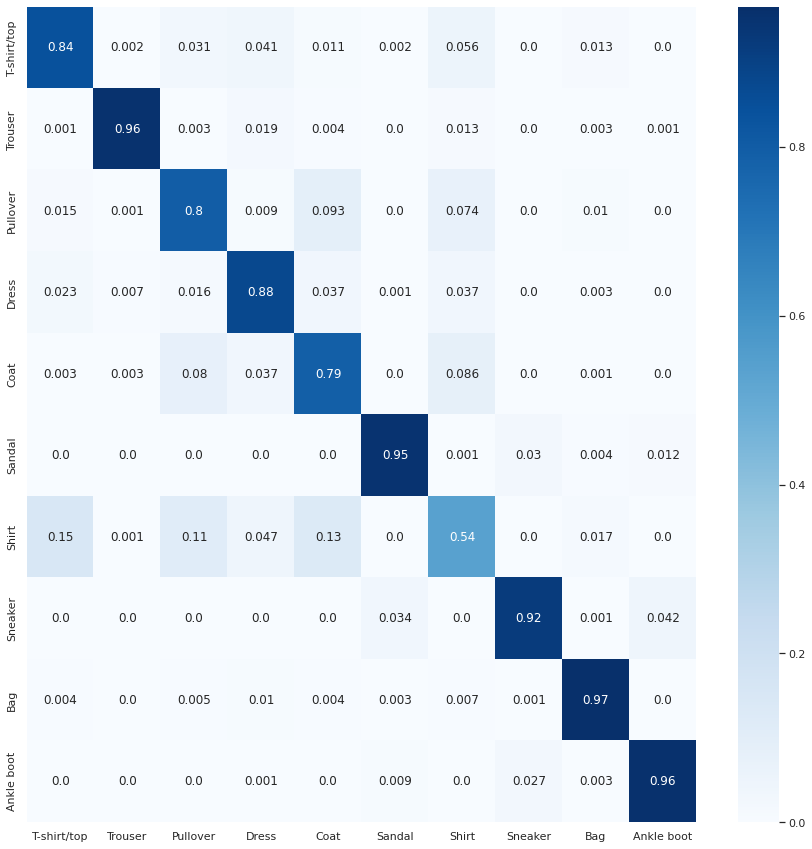

In [19]:
plot_confusion_matrix(test_labels,
                      predict_labels,
                      list(train_set.classes))

In [21]:
batch = next(iter(val_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([32, 3, 224, 224]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  Ankle boot, Pullover, Trouser, Trouser, Shirt, Trouser, Coat, Shirt, Sandal, Sneaker, 
Predicted:  Ankle boot, Pullover, Trouser, Trouser, Shirt, Trouser, Pullover, Shirt, Sandal, Sneaker, 

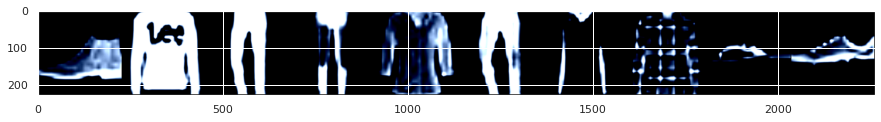

In [33]:
grid = torchvision.utils.make_grid(images[:10], nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("Labels: ", end=" ")
for i, label in enumerate(labels[:10]):
  print(val_set.classes[label], end=", ")

print("\nPredicted: ", end=" ")
for i, label in enumerate(predict_labels[:10]):
  print(val_set.classes[label], end=", ")

# Siamese network

In [147]:
class SiameseFashionMNIST(torchvision.datasets.FashionMNIST):
  def __init__(self, *args, **kwargs):
    super(SiameseFashionMNIST, self).__init__(*args, **kwargs)
    if kwargs["train"] is True:
      self.data, self.labels = self.train_data, self.train_labels
    else:
      self.data, self.labels = self.test_data, self.test_labels

  def __getitem__(self, idx):
    x1, t1 = self.data[idx], self.labels[idx]

    is_diff = random.randint(0, 1)
    while True:
      idx2 = random.randint(0, len(self)-1)
      x2, t2 = self.data[idx2], self.labels[idx2]
      if is_diff and t1 != t2:
        break
      if not is_diff and t1 == t2:
        break

    x1, x2 = Image.fromarray(x1.numpy()), Image.fromarray(x2.numpy())
    if self.transform is not None:
      x1, x2 = self.transform(x1), self.transform(x2)
    return x1, x2, int(is_diff), t1


siamese_data_transforms = transforms.Compose([
                              transforms.ToTensor(),
                              # transforms.Normalize(mean=[0.2860347330570221],
                              #                      std=[0.3530242443084717]),
                              ])

siamese_train_loader = torch.utils.data.DataLoader(
    SiameseFashionMNIST("./data",
                        download=True,
                        train=True,
                        transform=siamese_data_transforms),
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

siamese_test_loader = torch.utils.data.DataLoader(
    SiameseFashionMNIST("./data",
                        download=True,
                        train=False,
                        transform=siamese_data_transforms),
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=4)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [138]:
class Siamese(nn.Module):
  def __init__(self):
    super(Siamese, self).__init__()
    self.c1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.c2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.c3 = nn.Conv2d(64, 128, kernel_size=3, padding=0)
    self.bn3 = nn.BatchNorm2d(128)

    self.fc4 = nn.Linear(128, 64)
    self.bn4 = nn.BatchNorm1d(64)
    self.fc5 = nn.Linear(64, 2)

  def forward(self, x):
    h = F.max_pool2d(self.bn1(self.c1(x)), 2)
    h = F.max_pool2d(self.bn2(self.c2(h)), 2)
    h = F.avg_pool2d(self.bn3(self.c3(h)), 5)

    h = self.bn4(self.fc4(h.view(h.size(0), -1)))
    return self.fc5(h)


def contractive_loss(o1, o2, y):
  g, margin = F.pairwise_distance(o1, o2), 5.0
  loss = (1 - y) * (g ** 2) + y * (torch.clamp(margin - g, min=0) ** 2)
  return torch.mean(loss)

In [85]:
siamese_model = Siamese().cuda()

opt = optim.SGD(siamese_model.parameters(),
                lr=0.01,
                momentum=0.9)

scheduler = optim.lr_scheduler.MultiStepLR(opt, [5, 10], 0.1)
cudnn.benckmark = True

best_siamese_model_over_epochs = copy.deepcopy(siamese_model.state_dict())
best_loss = np.Inf

for e in range(20):
  scheduler.step()
  model.train()
  train_loss, train_n = 0, 0
  for x1, x2, y, label in tqdm(siamese_train_loader, total=len(siamese_train_loader), leave=False):
  # for x1, x2, y in siamese_train_loader:
    x1, x2 = Variable(x1.cuda()), Variable(x2.cuda())
    y = Variable(y.float().cuda()).view(y.size(0), 1)

    o1, o2 = siamese_model(x1), siamese_model(x2)
    loss = contractive_loss(o1, o2, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    train_loss = loss.detach().cpu().numpy() * y.size(0)
    train_n += y.size(0)

  siamese_model.eval()
  test_loss, test_n = 0, 0
  for x1, x2, y, label in tqdm(siamese_test_loader, total=len(siamese_test_loader), leave=False):
    x1, x2 = Variable(x1.cuda()), Variable(x2.cuda())
    y = Variable(y.float().cuda()).view(y.size(0), 1)

    o1, o2 = siamese_model(x1), siamese_model(x2)
    loss = contractive_loss(o1, o2, y)
    test_loss = loss.detach().cpu().numpy() * y.size(0)
    test_n += y.size(0)
  
  if best_loss > test_loss:
    best_loss = test_loss
    best_siamese_model_over_epochs = copy.deepcopy(siamese_model.state_dict())
    
  print("\t".join(["Epoch", "TrainLoss", "TestLoss"]))
  print("{}\t{:.6f}\t{:.6f}".format(e, train_loss / train_n, test_loss / test_n))

# Load best model weights
siamese_model.load_state_dict(best_siamese_model_over_epochs)

# Save best model weights
torch.save(siamese_model.state_dict(), path_to_models + f'siamese_model_weights_epoch-{20}_batch_size-{batch_size}.pth')

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch	TrainLoss	TestLoss
0	0.004165	0.011577


Epoch	TrainLoss	TestLoss
1	0.003884	0.010303


Epoch	TrainLoss	TestLoss
2	0.004108	0.012167


Epoch	TrainLoss	TestLoss
3	0.003876	0.012437


Epoch	TrainLoss	TestLoss
4	0.004325	0.010799


Epoch	TrainLoss	TestLoss
5	0.003762	0.012748


Epoch	TrainLoss	TestLoss
6	0.003933	0.011439


Epoch	TrainLoss	TestLoss
7	0.004029	0.010494


Epoch	TrainLoss	TestLoss
8	0.003921	0.014010


Epoch	TrainLoss	TestLoss
9	0.004409	0.011711


Epoch	TrainLoss	TestLoss
10	0.004145	0.013048


Epoch	TrainLoss	TestLoss
11	0.004067	0.012923


Epoch	TrainLoss	TestLoss
12	0.003343	0.009160


Epoch	TrainLoss	TestLoss
13	0.004058	0.010991


Epoch	TrainLoss	TestLoss
14	0.003760	0.012573


Epoch	TrainLoss	TestLoss
15	0.003906	0.014703


Epoch	TrainLoss	TestLoss
16	0.004221	0.012112


Epoch	TrainLoss	TestLoss
17	0.004134	0.012545


Epoch	TrainLoss	TestLoss
18	0.004297	0.010718


Epoch	TrainLoss	TestLoss
19	0.003717	0.017449


In [139]:
from matplotlib import offsetbox


siamese_model.eval()

inputs, embs, targets, labels = [], [], [], []
for x, x2, t, label in tqdm(siamese_test_loader, total=len(siamese_test_loader)):
# for x, x2, t in siamese_test_loader:
  x = Variable(x.cuda())
  o1 = siamese_model(x)
  inputs.extend(list(x.cpu().data.numpy()))
  embs.extend(list(o1.cpu().data.numpy()))
  targets.extend(list(t.numpy()))
  labels.extend(list(label.numpy()))

100%|██████████| 313/313 [00:01<00:00, 157.46it/s]


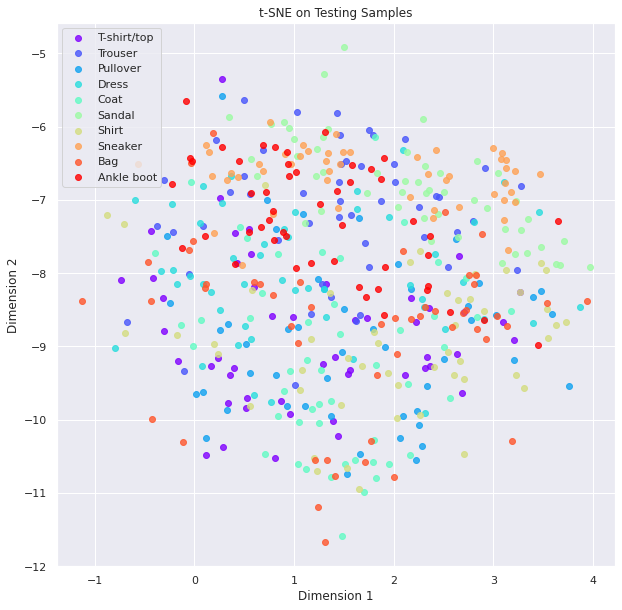

In [146]:
val_set.classes
obj_categories = val_set.classes

colors = plt.cm.rainbow(np.linspace(0, 1, len(obj_categories)))
plt.figure(figsize=(10, 10))

embs = np.array(embs)
labels = np.array(labels)

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(embs[np.where(labels == c_group), 0].flatten()[:50],
              embs[np.where(labels == c_group), 1].flatten()[:50],
              marker='o',
              color=c_color,
              linewidth='1',
              alpha=0.8,
              label=c_label)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

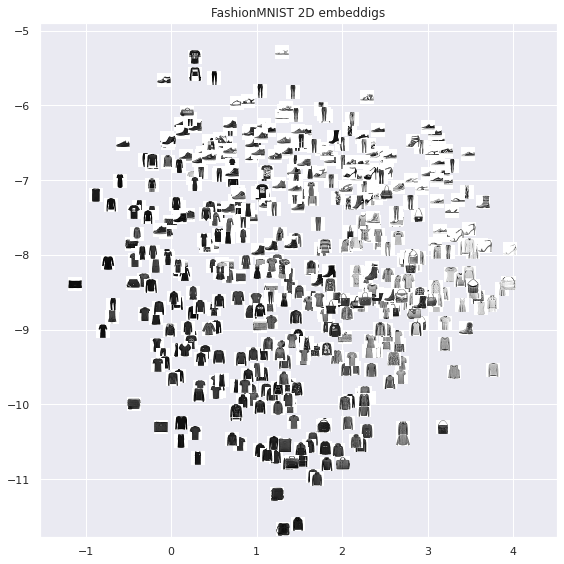

In [145]:
n_plots = 500
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
ax.set_title("FashionMNIST 2D embeddigs")
for x, e, t in zip(inputs[:n_plots], embs[:n_plots], targets[:n_plots]):
  imagebox = offsetbox.AnnotationBbox(
    offsetbox.OffsetImage(x.squeeze(0), zoom=0.5, cmap=plt.cm.gray_r),
    xy=e, frameon=False)
  ax.add_artist(imagebox)

ax.set_xlim(embs[:, 0].min(), embs[:, 0].max())
ax.set_ylim(embs[:, 1].min(), embs[:, 1].max())
plt.tight_layout()
plt.show()

In [20]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121') # we do not specify pretrained=True, i.e. do not load default weights

# # Set all model parameters to not update
# if feature_extract:
#   for param in model.parameters():
#     param.requires_grad = False

# # Reinitialize layer’s parameters
# in_features = model.classifier.in_features
# model.classifier = nn.Linear(in_features, num_classes)

# model.load_state_dict(torch.load(path_to_models + f'model_weights_epoch-{num_epochs}_batch_size-{batch_size}.pth'))
# model.eval()